## Renewables.ninja Wind (Point API) - 52.517, 13.389 - Version: 1.1 - License: https://creativecommons.org/licenses/by-nc/4.0/ - Reference: https://doi.org/10.1016/j.energy.2016.08.068
### Units: time in UTC, local_time in Europe/Berlin, electricity in kW
### {"units": {"time": "UTC", "local_time": "Europe/Berlin", "electricity": "kW"}, "params": {"local_time": true, "header": true, "lat": "52.5170365", "lon": "13.3888599", "date_from": "2017-01-01", "date_to": "2017-12-31", "dataset": "merra2", "capacity": "1", "height": "80", "turbine": "Vestas V90 2000", "raw": false}}

## Wind Turbine capacity = 1kW --> doubled for the simulation = 2kW

In [1]:
from google.colab import drive
drive.mount('/content/drive')

current_folder = 'drive/My Drive/DAI-Labor/RL_VPP_Thesis/data/'

input_folder = current_folder + 'datasets/'
output_folder = current_folder + 'scenario_datasets/'

Mounted at /content/drive


In [2]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import math

In [4]:
pv_data = pd.read_csv(input_folder + 'ninja_wind_51.0834_10.4234_corrected.csv')
pv_data = pv_data.drop(['local_time'], axis=1)
pv_data['time'] = pd.to_datetime(pv_data['time'])
#pv_data = pv_data.set_index("time")
#pv_data['time'] = pd.to_datetime(pv_data['time'], unit='ms')
index = len(pv_data['time'])
timestamp = pd.to_datetime("2018-01-01 00:00:00", format="%Y-%m-%d %H:%M:%S")
last_value = pv_data['electricity'][index-1]
new_row = pd.DataFrame([[timestamp, last_value]], columns=["time",'electricity'], index=[index])
pv_data = pd.concat([pv_data, pd.DataFrame(new_row)], ignore_index=False)

#Doubling capacity of PV to 2kW
pv_data['electricity'] = pv_data['electricity']*2

pv_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761 entries, 0 to 8760
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         8761 non-null   datetime64[ns]
 1   electricity  8761 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 205.3 KB


In [5]:
pv_data.head()

,time,electricity
0,2017-01-01 00:00:00,0.682
1,2017-01-01 01:00:00,0.646
2,2017-01-01 02:00:00,0.674
3,2017-01-01 03:00:00,0.734
4,2017-01-01 04:00:00,0.736


In [6]:
pv_data.tail()

,time,electricity
8756,2017-12-31 20:00:00,1.344
8757,2017-12-31 21:00:00,1.402
8758,2017-12-31 22:00:00,1.374
8759,2017-12-31 23:00:00,1.312
8760,2018-01-01 00:00:00,1.312


In [7]:
#pv_data['time'].resample("D").agg(["sum", "count"])
#pv_data.groupby(pd.TimeGrouper('15min'))[0].ohlc()
""" pv_data_1h = pv_data.resample('60min', on='time').agg({'time':'min','electricity':'min'})
pv_data_1h['time'] = pv_data_1h.index.values
pv_data_1h['electricity'].fillna(method='ffill', inplace=True)
pv_data_1h.head() """

#time_sampled = pv_data.resample('15min', on='time').time.sum

pv_data_15 = pv_data.resample('15min', on='time').agg({'time':'min','electricity':'min'})
""" pv_data_15 = pv_data.resample('15min', on='time').last() """
pv_data_15['time'] = pv_data_15.index.values
pv_data_15['electricity'].fillna(method='ffill', inplace=True)
pv_data_15.tail()

#print(time_sampled)



,time,electricity
time,,
2017-12-31 23:00:00,2017-12-31 23:00:00,1.312
2017-12-31 23:15:00,2017-12-31 23:15:00,1.312
2017-12-31 23:30:00,2017-12-31 23:30:00,1.312
2017-12-31 23:45:00,2017-12-31 23:45:00,1.312
2018-01-01 00:00:00,2018-01-01 00:00:00,1.312


In [8]:
# splitting dataframe by row index
#pv_data = pv_data.iloc[:1000,:]
#df_2 = df.iloc[1000:,:]
#print("Shape of new dataframes - {} , {}".format(df_1.shape, df_2.shape))

""" pv_data_1h = pv_data_15.loc['2017-06-01 00:00:00':'2018-01-01 00:00:00'] """
pv_data_ = pv_data_15.loc['2017-01-01 00:00:00':'2018-01-01 00:00:00']
pv_data_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2017-01-01 00:00:00 to 2018-01-01 00:00:00
Freq: 15T
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         35041 non-null  datetime64[ns]
 1   electricity  35041 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 821.3 KB


In [9]:
pv_data_.head()

,time,electricity
time,,
2017-01-01 00:00:00,2017-01-01 00:00:00,0.682
2017-01-01 00:15:00,2017-01-01 00:15:00,0.682
2017-01-01 00:30:00,2017-01-01 00:30:00,0.682
2017-01-01 00:45:00,2017-01-01 00:45:00,0.682
2017-01-01 01:00:00,2017-01-01 01:00:00,0.646


In [10]:
household_csv = pv_data_.to_csv(output_folder + 'WT_load_test_year_15.csv', index = True)

In [11]:
#pv_data = pv_data.iloc[:,:1]

pv_data = pv_data_.drop(['time'], axis=1)
#df_2 = df.iloc[1000:,:]
#print("Shape of new dataframes - {} , {}".format(df_1.shape, df_2.shape))
pv_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2017-01-01 00:00:00 to 2018-01-01 00:00:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   electricity  35041 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


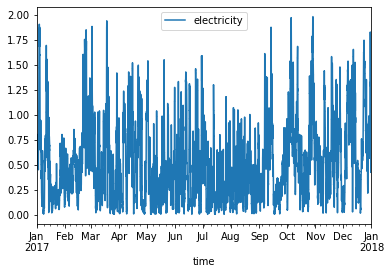

In [12]:
pv_data.plot()
#pv_data.plot(legend=None)
#plt.show()